Download http://download.tensorflow.org/example_images/flower_photos.tgz

> tar -xvzf flower_photos.tgz

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# Cargar imagenes

In [2]:
path = 'flower_photos/'
img_size = 224
batch_size = 64

In [30]:
train_datagen = ImageDataGenerator(preprocessing_function=None)

train_generator = train_datagen.flow_from_directory(path, shuffle=False,
    target_size=(img_size, img_size), batch_size=batch_size)

Found 3670 images belonging to 5 classes.


In [31]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

dandelion/8756906129_b05a1b26f2.jpg


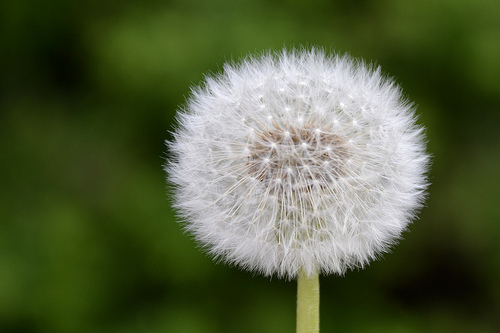

In [32]:
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + random_img)

In [33]:
batch_x, batch_y = train_generator.next()
batch_x.shape, batch_y.shape

((64, 224, 224, 3), (64, 5))

# Cargar la red entrenada

In [34]:
model = ResNet50(include_top=False)
model.summary()

92004352/94653016 [============================>.] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
_______________________________

In [35]:
model.input, model.output

(<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'avg_pool/AvgPool:0' shape=(?, ?, ?, 2048) dtype=float32>)

In [36]:
t0 = time()
output = model.predict_on_batch(batch_x)
elapsed = time() - t0
output.shape, elapsed

((64, 1, 1, 2048), 14.551310062408447)

In [37]:
print('%.2f minutos por epoch.' % ((train_generator.samples // batch_size) * elapsed / 60))

13.82 minutos por epoch.


# Precompute

In [38]:
n_batch = train_generator.samples // batch_size
n_batch

57

In [ ]:
train_generator.reset()
outputs_x = []
outputs_y = []

for i in range(n_batch):
    print('%d/%d...' % (i+1, n_batch), end='\r')
    batch_x, batch_y = train_generator.next()
    outputs_x.append(model.predict_on_batch(batch_x))
    outputs_y.append(batch_y)

In [ ]:
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

In [ ]:
# Redimensionando
outputs_x = outputs_x[:,0,0,:]
outputs_x.shape, outputs_y.shape

In [ ]:
outputs_x[0], outputs_y[0]

In [ ]:
# # Guardar arrays
# np.savez_compressed('3-outputs', x=outputs_x, y=outputs_y)

In [39]:
# Cargar arrays
outputs_x = np.load('3-outputs.npz')['x']
outputs_y = np.load('3-outputs.npz')['y']

In [40]:
outputs_x.shape, outputs_y.shape

((3648, 2048), (3648, 5))

# Entrenar a partir de los features extraidos

In [82]:
flowers_model = Sequential()
flowers_model.add(Dense(128, activation='relu', input_shape=(2048,)))
flowers_model.add(Dropout(0.5))
flowers_model.add(Dense(5, activation='softmax'))
flowers_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
flowers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 262,917
Trainable params: 262,917
Non-trainable params: 0
_________________________________________________________________


In [84]:
log = flowers_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
3648/3648 [==============================] - 0s - loss: 0.1876 - acc: 0.9370     
Epoch 2/5
3648/3648 [==============================] - 0s - loss: 0.1622 - acc: 0.9427     
Epoch 3/5
3648/3648 [==============================] - 0s - loss: 0.1398 - acc: 0.9531     
Epoch 4/5
3648/3648 [==============================] - 0s - loss: 0.1257 - acc: 0.9553     
Epoch 5/5
3648/3648 [==============================] - 0s - loss: 0.1170 - acc: 0.9592     


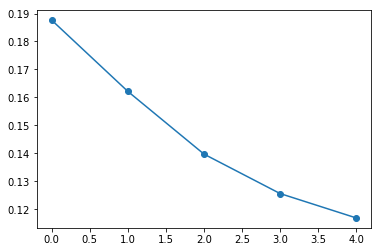

In [85]:
plt.plot(log.history['loss'], '-o');

# Definiendo el modelo completo

In [86]:
base_model = ResNet50(include_top=False)

In [87]:
final_model = Sequential()
final_model.add(base_model)
final_model.add(flowers_model)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_3 (Sequential)    multiple                  262917    
Total params: 23,850,629
Trainable params: 23,797,509
Non-trainable params: 53,120
_________________________________________________________________


# Usando el modelo

roses/2053476785_c162a3e358.jpg


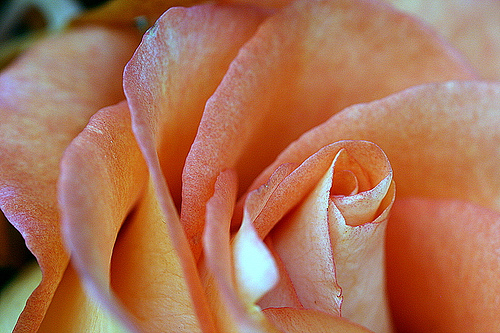

In [52]:
random_img = np.random.choice(train_generator.filenames)
print(random_img)
img = Image.open(path + random_img)
img

In [53]:
img = img.resize((224,224))
x = np.asarray(img, np.float32)[None]
x.shape

(1, 224, 224, 3)

In [55]:
y = final_model.predict(x)
y.shape

(1, 1, 1, 5)

In [56]:
y = y[0,0,0]
y.shape

(5,)

In [60]:
pred = np.argmax(y)
pred

2

In [62]:
# Se crea un diccionario de indice a clase
index2class = {train_generator.class_indices[k]:k for k in train_generator.class_indices}
index2class

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [63]:
# Usando el diccionario y la funcion np.argmax, obtener el nombre de la clase predecida
index2class[pred]

'roses'

# Resumiendo en una funcion

In [88]:
def get_class(path):
    print(path)
    img = Image.open('flower_photos/' + path)
    img = img.resize((224,224))
    x = np.asarray(img, np.float32)[None]
    y = final_model.predict(x)
    y = y[0,0,0]
    pred = np.argmax(y)
    plt.imshow(img)
    plt.axis('off')
    
    return index2class[pred]

roses/4248222578_b4d5868b32.jpg


'tulips'

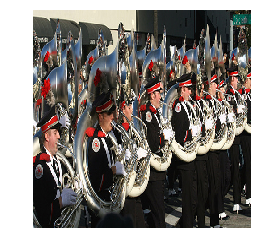

In [92]:
get_class(np.random.choice(train_generator.filenames))